# 1. Подготовка

In [1]:
# вызов библиотеки Pandas
import pandas as pd
# импорт библиотеки numpy
import numpy as np
# вызов функции деления выборки
from sklearn.model_selection import train_test_split
# импорт библиотеки seaborn
import seaborn as sns
# импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# импорт функции расчета MSE
from sklearn.metrics import mean_squared_error
# импорт метрики make_scorer
from sklearn.metrics import make_scorer
# импорт функции кросс-валидации
from sklearn.model_selection import cross_val_score
# импорт функции seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# исследование данных
data_taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Просмотр данных в таблице
data_taxi.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# Просмотр информации по структуре таблице
print(data_taxi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


In [5]:
# Изменим тип данных Datetime с object на datetime6
data_taxi['datetime']= pd.to_datetime(data_taxi['datetime'])

In [6]:
# Определим количество пропусков
data_taxi.isnull().sum()

datetime      0
num_orders    0
dtype: int64

*Пропусков в данных нет*

In [7]:
# Поиск дубликатов по таблице
data_taxi.duplicated().sum()

0

*В таблице дублирующих записей нет*

In [8]:
# Поиск уникальных значений по колонке "Количество заказов"
print(len(data_taxi["num_orders"].unique()))

81


*По колонке "Количество заказов" найдено 81 уникальное значение*

In [9]:
# Установим индекс таблицы
data_taxi.set_index('datetime', inplace=True)

In [10]:
# Отсортируем таблицу по индексу
data_taxi = data_taxi.sort_index()
# Проверим отображение значений в хронологическом порядке
print(data_taxi.index.is_monotonic)

True


*Данные отсортированы в хронологическом порядке*

In [11]:
# Выполним ресемплирование по 1 часу
data_taxi = data_taxi.resample('1H').sum()

In [12]:
# Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(data_taxi)
#decomposed.seasonal = decomposed.seasonal['2018-06-01':'2018-07-01']

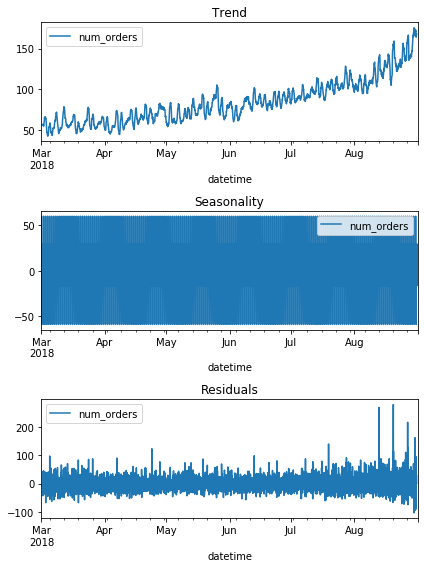

In [13]:
# Построим график вывода составляющих
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')


plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)


decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

                     num_orders  rolling_mean
datetime                                     
2018-03-01 00:00:00         124           NaN
2018-03-01 01:00:00          85           NaN
2018-03-01 02:00:00          71           NaN
2018-03-01 03:00:00          66           NaN
2018-03-01 04:00:00          43           NaN
...                         ...           ...
2018-08-31 19:00:00         136         166.6
2018-08-31 20:00:00         154         162.9
2018-08-31 21:00:00         159         162.1
2018-08-31 22:00:00         223         170.8
2018-08-31 23:00:00         205         174.7

[4416 rows x 2 columns]


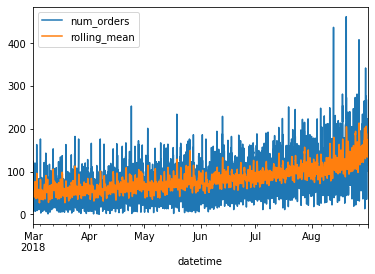

In [14]:
# В таблицу добавим колонку со скользящим средним с размером окна 10
data_taxi['rolling_mean'] = data_taxi.rolling(10).mean()
print(data_taxi)
# Построим график в том числе со скользящим средним
data_taxi.plot()

#### Вывод
1. Таблица data_taxi содержит 2 колонки-признака.
2. Таблица data_taxi содержит 26496 строк-объектов.
3. В таблице data_taxi нет пропусков, нет дублей.
4. В таблице data_taxi 81 уникальных значений.
5. В таблице data_taxi по колонке "Количество заказов" (num_orders) данные отсортированы в хронологическом порядке.
6. В таблицу data_taxi добавлена колонка rolling_mean, в которой отображается скользящее среднее с окном 10.

# 2. Анализ

In [15]:
# Изучим информацию в колонке "Количество заказов"
data_taxi["num_orders"].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

*Среднее количество заказов - 84.42*

In [16]:
# Функция создания новых признаков, размера отставания, скользящего среднего
def make_features(data_taxi, max_lag, rolling_mean_size):
    data_taxi['month'] = data_taxi.index.month
    data_taxi['day'] = data_taxi.index.day
    data_taxi['dayofweek'] = data_taxi.index.dayofweek
    data_taxi['hour'] = data_taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        data_taxi['lag_{}'.format(lag)] = data_taxi['num_orders'].shift(lag)
    
    data_taxi['rolling_mean_shift'] = data_taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data_taxi, 6, 6)

Новые календарные признаки для горизонта прогнозирования:
1. Фактор год не информативен, потому что все данные за 2018 год
2. Фактор месяц. Количество заказов такси может зависеть от времени года или зависеть от конкретного месяца (например, месяцы с большим количеством праздничных и выходных дней).
3. Фактор день. Количество заказов может зависеть от конкретного дня (дня месяца). Например, больше заказов в праздничные дни
4. Фактор день недели. Количество заказов такси может зависеть от рабочего дня недели или от выходных.
5. Фактор час. Количество заказов такси может зависеть от времени суток. Например, ночью заказов может быть больше чем утром или днем.

Отстающие (предыдущие) значения lag временного ряда подскажут, будет ли функция расти или уменьшаться. 

Скользящее среднее rolling_mean как признак задаёт общий тренд временного ряда

In [17]:
# Посмотр таблицы с новыми колонками-признаками
data_taxi.head(5)

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean_shift
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


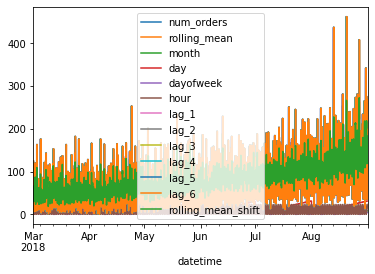

In [18]:
# Построим график
data_taxi.plot()

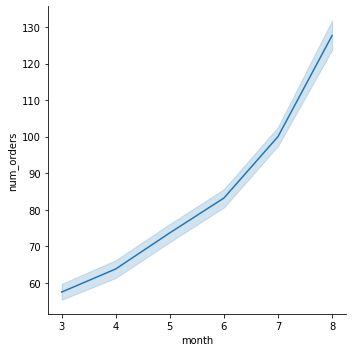

In [19]:
# График зависимости количества заказов от месяца
sns.relplot(x="month", y="num_orders", kind="line", data=data_taxi)

*Наибольшее количество заказов было в августе. Наименьшее количество заказов было в марте. Количесто заказов непрерывно росло за весь наблюдаемый период*

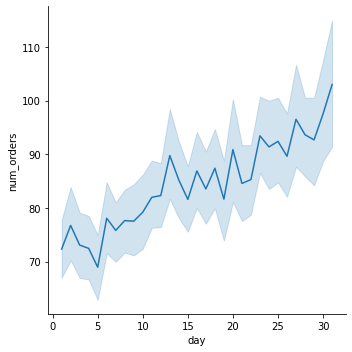

In [20]:
# График зависимости количества заказов от дня месяца
sns.relplot(x="day", y="num_orders", kind="line", data=data_taxi)

*Наибольшее количество заказов наблюдается в конце месяца. Наименьшее количество заказов наблюдается в начале месяца. За наблюдаемый период (дни месяца) наблюдается увеличение вызовов*

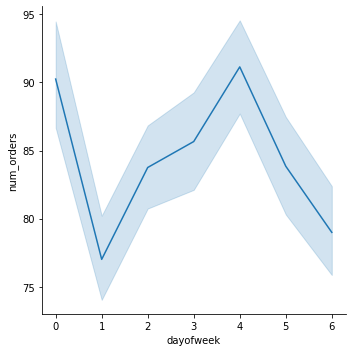

In [21]:
# График зависимости количества заказов от дня недели
sns.relplot(x="dayofweek", y="num_orders", kind="line", data=data_taxi)

*Наибольшее количество заказов наблюдалось в пятницу (4) и понедельник (0). Наименьшее количество вызовов наблюдалось во вторник (1) и в воскресенье (6)*

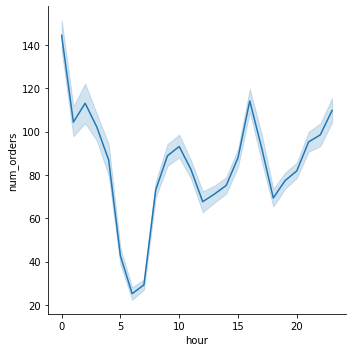

In [22]:
# График зависимости количества вызовов в закисимости от часа вызова
sns.relplot(x="hour", y="num_orders", kind="line", data=data_taxi)

*Наибольшее количество заказов наблюдалось ночью - примерно в 00:00. Наименьшее количество заказов - рано утром, примерно 05:00 - 06:00*

#### Вывод
1. Среднее количество заказов - 84.42.
2. Наибольшее количество заказов было в августе. Наименьшее количество заказов было в марте. Количесто вывозов непрерывно росло за весь наблюдаемый период.
3. Наибольшее количество заказов наблюдается в конце месяца. Наименьшее количество заказов наблюдается в начале месяца. За наблюдаемый период (дни месяца) наблюдается увеличение вызовов.
4. Наибольшее количество заказов наблюдалось в пятницу (4) и понедельник (0). Наименьшее количество вызовов наблюдалось во вторник (1) и в воскресенье (6).
5. Наибольшее количество заказов наблюдалось ночью - примерно в 00:00. Наименьшее количество заказов - рано утром, примерно 05:00 - 06:00.

# 3. Обучение

In [23]:
# Разделим таблицу data_taxi на обучающую и тестовую выборки (размер тестовой - 10% от исходных данных)
train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.shape)
print(test.shape)

(3965, 13)
(442, 13)


In [24]:
# проверка размерности тренировочной и тестовой выборок 
def size(data_taxi,train,test):
    size_data = len(data_taxi.index)
    size_train = len(train.index)
    size_test = len(test.index)
    print("Обучающая выборка ", size_train*100/size_data)
    print("Тестовая выборка ", size_test*100/size_data)
    return 
size(data_taxi,train,test)

Обучающая выборка  89.78713768115942
Тестовая выборка  10.009057971014492


In [25]:
# Признаки обучающей выборки
features_train = train.drop(['num_orders'], axis=1)
# Целевой признак обучающей выборки
target_train = train['num_orders']
# Признаки тестовой выборки
features_test = test.drop(['num_orders'], axis=1)
# Целевой признак тестовой выборки
target_test = test['num_orders']

*Целевой признак - количество заказов. Решаем задачу регресии*

In [26]:
# Функция для расчета RMSE
def RMSE(target, predict):
    return np.sqrt(mean_squared_error(target, predict))

my_scoring = make_scorer(RMSE, greater_is_better = False)

#### Исследование модели "Дерево решений в регресии"

In [27]:
# импорт из библиотеки sklearn структуры данных модели "Дерево решений в регрессии"
from sklearn.tree import DecisionTreeRegressor

In [28]:
# создание модели методом "Дерево решений в регрессии"
# Напишем циклы для max_depth от 1 до 10 и samples_leaf от 2 до 10
min_score1 = 100
for depth in range(3, 9):
    for samples_leaf in range(2, 10):
        model_DTR = DecisionTreeRegressor(random_state=12345, 
                                          max_depth=depth, 
                                          min_samples_leaf = samples_leaf)

        # обучение модели на Обучающей выборке для каждого целевого показателя
        model_DTR.fit(features_train, target_train)

        # Оценка качества модели кросс-валидацией с учетом значений гиперпараметров
        print('max_depth=', depth, "min_samples_leaf =", samples_leaf, " -- ", end='')
        score_DTR = cross_val_score(model_DTR, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring = my_scoring)
        if min_score1 > score_DTR.mean():
            min_score1 = score_DTR.mean()
        print(score_DTR.mean())

max_depth= 3 min_samples_leaf = 2  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 3  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 4  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 5  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 6  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 7  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 8  -- -29.089964681942156
max_depth= 3 min_samples_leaf = 9  -- -29.089964681942156
max_depth= 4 min_samples_leaf = 2  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 3  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 4  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 5  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 6  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 7  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 8  -- -27.32507162515781
max_depth= 4 min_samples_leaf = 9  -- -27.32507162515781
max_depth= 5 min_samples_leaf = 2  -- -26.845985261455375
max_depth= 5 min_sampl

In [29]:
# Оформим результаты в таблицу
df_models = pd.DataFrame({'model':['DecisionTreeRegressor'],'score':[min_score1]}) 
df_models

,model,score
0,DecisionTreeRegressor,-29.089965


#### Исследование модели "Случайный лес в регресии"

In [30]:
# импорт из библиотеки sklearn структуры данных модели "Случайный лес в регрессии"
from sklearn.ensemble import RandomForestRegressor

In [31]:
# Настроим гиперпараметрs метода "Случайный лес в регрессии" - max_depth и n_estimators 
# (количество деревьев в лесу)
# Напишем цикл для количества дереьев в случайном лесу
min_score2 = 100
for depth in range(3, 5, 2):
    for estim in range(4, 101, 25):
        # создание модели методом "Случайный лес в регрессии"
        model_RFG = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=estim)
        # обучение модели
        model_RFG.fit(features_train, target_train)

        # Оценка качества модели кросс-валидацией
        print('max_depth=', depth, ',', "n_estimators =", estim, " -- ", end='')
        score_RFG = cross_val_score(model_RFG, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring = my_scoring)
        if min_score2 > score_RFG.mean():
            min_score2 = score_RFG.mean()
        print(score_RFG.mean())

max_depth= 3 , n_estimators = 4  -- -28.342545887822865
max_depth= 3 , n_estimators = 29  -- -27.816628147136008
max_depth= 3 , n_estimators = 54  -- -27.8381688270132
max_depth= 3 , n_estimators = 79  -- -27.836768446757038


In [32]:
# Оформим результаты в таблицу
df_models.loc[1] = ['RandomForestRegressor', min_score2]
df_models

,model,score
0,DecisionTreeRegressor,-29.089965
1,RandomForestRegressor,-28.342546


#### Исследование модели "Линейная регрессия"

In [33]:
# импорт из библиотеки sklearn структуры данных модели "Линейная регрессия"
from sklearn.linear_model import LinearRegression

In [34]:
# создание модели методом "Линейная регрессия"
model_LR = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# обучение модели на Обучающей выборке для каждого целевого показателя
model_LR.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
# Оценка качества модели кросс-валидацией
score_LR = cross_val_score(model_LR, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring = my_scoring)
print(score_LR.mean())

-27.8350513362789


In [37]:
# Оформим результаты в таблицу
df_models.loc[2] = ['LinearRegression', score_LR.mean()]
df_models

,model,score
0,DecisionTreeRegressor,-29.089965
1,RandomForestRegressor,-28.342546
2,LinearRegression,-27.835051


In [38]:
min_score = df_models[df_models['score'] == df_models['score'].max()]
print(min_score)

              model      score
2  LinearRegression -27.835051


#### Вывод
Лучшей моделью можно считать модель - Линейная регрессия (RSME=27,84)

# 4. Тестирование

In [39]:
# тестирование модели "Линейная регрессия"
# предсказание тестовой выборки 
test_predictions_LR = model_LR.predict(features_test)

# Расчет MSE модели "Линейная регрессия" на тестовой выборке
mse_test_LR = mean_squared_error(target_test, test_predictions_LR)

# Расчет RMSE модели "Линейная регрессия" на тестовой выборке
rmse_test_LR = mse_test_LR ** 0.5
print("RMSE на тестовой выборке:", rmse_test_LR)

RMSE на тестовой выборке: 46.296226061948154


In [40]:
# Выведем список предсказаний в отдельную таблицу
pd.DataFrame(test_predictions_LR)

,0
0,91.403229
1,94.866163
2,123.880458
3,140.972730
4,149.686360
...,...
437,180.637830
438,157.940637
439,157.316736
440,157.172895


In [41]:
# Функция расчета фактических и предсказанных значений
def ttt(prediction, target, df_):
    df_['fact'] = target
    df_['prediction'] = prediction

df_ttt = pd.DataFrame()
ttt(test_predictions_LR,target_test,df_ttt)

In [42]:
# Таблица с фактическими данными и предсказанными данными
df_ttt.head(5)

,fact,prediction
datetime,,
2018-08-13 14:00:00,102,91.403229
2018-08-13 15:00:00,175,94.866163
2018-08-13 16:00:00,144,123.880458
2018-08-13 17:00:00,152,140.972730
2018-08-13 18:00:00,104,149.686360


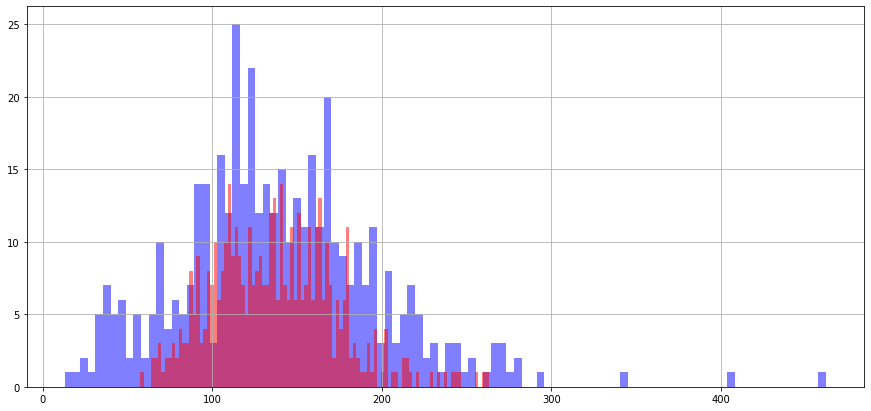

In [43]:
# Построим график сравнения предсказанных и фактических значений
plt.figure(figsize=(15,7))
df_ttt['fact'].hist(alpha=0.5, color='blue', bins=100)
df_ttt['prediction'].hist(alpha=0.5, color='red', bins=100)

#### Вывод
Лучшей моделью является "Линейная регрессия":
1. RMSE на обучающей выборке: 27,84
2. RMSE на тестовой выборке: 46,3

Предсказанные значения на порядок меньше фактических значений